In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.datasets import load_dataset, preprocess_dataset, prefetch_dataset
from src.utils import *

2024-02-01 12:10:43.718156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 12:10:43.718220: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 12:10:43.718238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 12:10:43.725051: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cfg = { 'dataset' : 'stl10',
        'model' : 'pretrained_inception',
        'batch_size' : 512,
        'optimizer' : 'Adam',
        'learning_rate' : 0.001,
        'max_epoch' : 300,
        'patience' : 10,}    

model_name = cfg['model']
dataset_name = cfg['dataset']

### Softmax

2024-02-01 12:11:09.330763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78835 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-02-01 12:11:35.955092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906


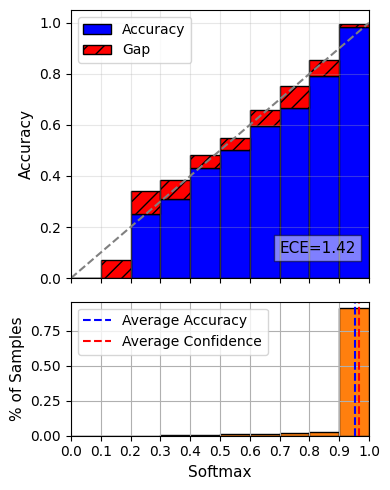

In [3]:
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=True, normalize=True, onehot=True)

bin_counts = []
bin_acc = []
bin_conf = []
avg_acc = []
avg_conf = []
gaps = []
ece = []

all_result = {}

for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
#     print(f'Run: {run+1}')
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    preds = model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
    true_y = np.argmax([y for x,y in ds_test], axis=1)
    pred_y = np.argmax(preds, axis=1)
    true_label = np.equal(true_y, pred_y).astype(int) # assign 0 if true_y != pred_y, assign 1 if true_y == pred_y
    softmax_val = np.max(preds, axis=1)
    
    result = reliability_diagram(softmax_val, true_y, pred_y, n_bins=10)
    
    bin_counts.append(result['bin_counts'])
    bin_acc.append(result['bin_acc'])
    bin_conf.append(result['bin_conf'])
    avg_acc.append(result['avg_acc'])
    avg_conf.append(result['avg_conf'])
    gaps.append(result['gaps'])
    ece.append(result['ece'])
    
all_result = {
    'bins' : result['bins'],
    'bin_size' : result['bin_size'],
    'bin_counts' : np.mean(bin_counts, axis=0),
    'bin_acc' : np.mean(bin_acc, axis=0),
    'bin_conf' : np.mean(bin_conf, axis=0),
    'avg_acc' : np.mean(avg_acc),
    'avg_conf' : np.mean(avg_conf),
    'gaps' : np.mean(gaps, axis=0),
    'ece' : np.mean(ece)
}

plot_reliability_diagram(all_result, metric = 'Softmax')

### PMI

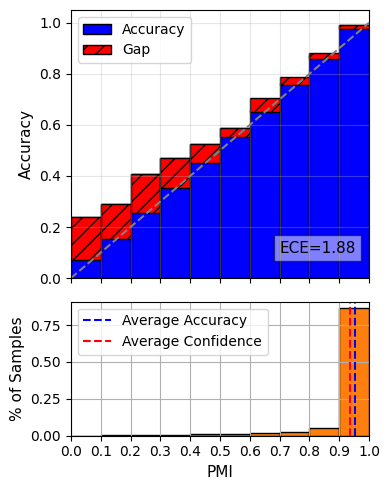

In [4]:
critic = 'separable'
estimator = 'density_ratio_fitting'

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=True, normalize=True, onehot=True)

bin_counts = []
bin_acc = []
bin_conf = []
avg_acc = []
avg_conf = []
gaps = []
ece = []

all_result = {}

for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    preds = model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
    true_y = np.argmax([y for x,y in ds_test], axis=1)
    pred_y = np.argmax(preds, axis=1)
    true_label = np.equal(true_y, pred_y).astype(int) # assign 0 if true_y != pred_y, assign 1 if true_y == pred_y
    
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pmi/{critic}_{estimator}'
    pmi_class = np.load(f'{exp_name}/pmi_class_test.npy')
    pmi_class = np.array([softmax(x) for x in pmi_class])
    pmi = np.array([pmi_value[pred_value] for pmi_value, pred_value in zip(pmi_class, pred_y)])
    
    result = reliability_diagram(pmi, true_y, pred_y, n_bins=10)
    
    bin_counts.append(result['bin_counts'])
    bin_acc.append(result['bin_acc'])
    bin_conf.append(result['bin_conf'])
    avg_acc.append(result['avg_acc'])
    avg_conf.append(result['avg_conf'])
    gaps.append(result['gaps'])
    ece.append(result['ece'])
    
all_result = {
    'bins' : result['bins'],
    'bin_size' : result['bin_size'],
    'bin_counts' : np.mean(bin_counts, axis=0),
    'bin_acc' : np.mean(bin_acc, axis=0),
    'bin_conf' : np.mean(bin_conf, axis=0),
    'avg_acc' : np.mean(avg_acc),
    'avg_conf' : np.mean(avg_conf),
    'gaps' : np.mean(gaps, axis=0),
    'ece' : np.mean(ece)
}

plot_reliability_diagram(all_result, metric='PMI')